## Final Project Submission

Please fill out:
* Student name: Linh Mai
* Student pace: self paced 
* Scheduled project review date/time: June 3rd, 2020
* Instructor name: Jeff Herman
* Blog post URL: https://linhmai19.github.io/

## Import Libraries and the cleaned dataset 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 
plt.style.use('seaborn')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import scipy.stats as stats

In [4]:
df = pd.read_csv('cleaned_kc_house_data.csv')
df.head()

,Unnamed: 0,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_sold,zip_98008_98028,zip_98028_98038,zip_98038_98053,zip_98053_98065,zip_98065_98103,zip_98103_98115,zip_98115_98125,zip_98125_98155,zip_98155_98200
0,0,221900.0,0.333333,0.090909,0.369910,0.661603,0.000000,0.0,0.0,0.333333,...,2014,0,0,0,0,0,0,0,0,1
1,1,538000.0,0.333333,0.545455,0.756227,0.730449,0.553295,0.0,0.0,0.333333,...,2014,0,0,0,0,0,0,1,0,0
2,2,180000.0,0.000000,0.090909,0.158049,0.819942,0.000000,0.0,0.0,0.333333,...,2015,1,0,0,0,0,0,0,0,0
3,3,604000.0,0.666667,0.818182,0.621749,0.627708,0.000000,0.0,0.0,1.000000,...,2014,0,0,0,0,0,0,0,1,0
4,4,510000.0,0.333333,0.454545,0.545243,0.760816,0.000000,0.0,0.0,0.333333,...,2015,0,0,0,0,1,0,0,0,0


In [5]:
df = df.drop('Unnamed: 0', 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_sold,zip_98008_98028,zip_98028_98038,zip_98038_98053,zip_98053_98065,zip_98065_98103,zip_98103_98115,zip_98115_98125,zip_98125_98155,zip_98155_98200
0,221900.0,0.333333,0.090909,0.369910,0.661603,0.000000,0.0,0.0,0.333333,0.333333,...,2014,0,0,0,0,0,0,0,0,1
1,538000.0,0.333333,0.545455,0.756227,0.730449,0.553295,0.0,0.0,0.333333,0.333333,...,2014,0,0,0,0,0,0,1,0,0
2,180000.0,0.000000,0.090909,0.158049,0.819942,0.000000,0.0,0.0,0.333333,0.000000,...,2015,1,0,0,0,0,0,0,0,0
3,604000.0,0.666667,0.818182,0.621749,0.627708,0.000000,0.0,0.0,1.000000,0.333333,...,2014,0,0,0,0,0,0,0,1,0
4,510000.0,0.333333,0.454545,0.545243,0.760816,0.000000,0.0,0.0,0.333333,0.666667,...,2015,0,0,0,0,1,0,0,0,0


## Build the Model

In [6]:
# Define the features and target
X = df.drop('price', axis=1)
y = df[['price']]

# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the length of each data set
print(len(X_train), len(X_test), len(y_train), len(y_test))

13291 3323 13291 3323


In [7]:
# Create an instance of the model
linreg = LinearRegression()

# Fit the model
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
# Calculate predictions on training and testing datasets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# Calculating MSE by using Scikit-Learn's Mean Squared Error function
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 15494173166.35873
Test Mean Squarred Error: 15812815642.073904


In [9]:
# Calculate the percentage of difference between the train and test MSE
print((test_mse-train_mse)/train_mse)

0.0205653100874732


The difference between train and test MSE scores is small.

Checking for the R-squared and Adj.R-squared values

In [10]:
outcome = 'price'
predictors = df.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     1011.
Date:                Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                        17:33:16   Log-Likelihood:            -2.1852e+05
No. Observations:               16614   AIC:                         4.371e+05
Df Residuals:                   16591   BIC:                         4.373e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -2.92e+07   4.19e+06     -6.976      0.000   -3.74e+07    -2.1e+07
bedrooms        -3.612e+04   4947.484     -7.300      0.000   -4.58e+04   -2.64e+04
bathrooms        4.395e+04   7043.053      6.240      0.000    3.01e+04    5.78e+04
sqft_living      3.009e+05   1.18e+04     25.599      0.000    2.78e+05    3.24e+05
sqft_lot         -1.42e+05   8972.059    -15.829      0.000    -1.6e+05   -1.24e+05
floors           1.837e+04   5826.434      3.153      0.002    6949.802    2.98e+04
waterfront       1.946e+05   3.11e+04      6.253      0.000    1.34e+05    2.56e+05
view             1.136e+05   7313.150     15.537      0.000    9.93e+04    1.28e+05
condition        7.207e+04   5025.441     14.340      0.000    6.22e+04    8.19e+04
grade            2.701e+05   5394.141     50.065      0.000    2.59e+05    2.81e+05
basement         6676.0728   2618.958      2.549      0.011    1542.635    1.18e+04
yr_built        -2249.6640     51.222    -43.919      0.000   -2350.066   -2149.262
sqft_living15    2.307e+05   9489.168     24.307      0.000    2.12e+05    2.49e+05
yr_sold          1.674e+04   2077.584      8.056      0.000    1.27e+04    2.08e+04
zip_98008_98028 -7.472e+04   4581.957    -16.307      0.000   -8.37e+04   -6.57e+04
zip_98028_98038 -3.292e+04   4180.762     -7.874      0.000   -4.11e+04   -2.47e+04
zip_98038_98053  2.538e+04   4635.733      5.474      0.000    1.63e+04    3.45e+04
zip_98053_98065 -7.743e+04   4543.824    -17.040      0.000   -8.63e+04   -6.85e+04
zip_98065_98103  1.607e+04   4663.402      3.445      0.001    6925.322    2.52e+04
zip_98103_98115  4.998e+04   4862.091     10.279      0.000    4.04e+04    5.95e+04
zip_98115_98125  3.416e+04   4638.574      7.365      0.000    2.51e+04    4.33e+04
zip_98125_98155 -1.425e+04   4413.510     -3.230      0.001   -2.29e+04   -5603.626
zip_98155_98200  -5.43e+04   4664.794    -11.640      0.000   -6.34e+04   -4.52e+04
==============================================================================
Omnibus:                      632.392   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              919.918
Skew:                           0.375   Prob(JB):                    1.75e-200
Kurtosis:                       3.875   Cond. No.                     1.22e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Check for Linearity 

In [11]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_sold,zip_98008_98028,zip_98028_98038,zip_98038_98053,zip_98053_98065,zip_98065_98103,zip_98103_98115,zip_98115_98125,zip_98125_98155,zip_98155_98200
count,1.661400e+04,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,...,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000,16614.000000
mean,4.543664e+05,0.425545,0.451344,0.563825,0.683634,0.253069,0.001023,0.035452,0.473476,0.470025,...,2014.322138,0.085410,0.128085,0.082701,0.089804,0.088961,0.099434,0.120802,0.121584,0.086433
std,1.908357e+05,0.259733,0.236103,0.175068,0.166174,0.281572,0.031973,0.143031,0.215325,0.270611,...,0.467310,0.279499,0.334194,0.275439,0.285909,0.284696,0.299253,0.325907,0.326815,0.281011
min,8.200000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.073375e+05,0.333333,0.272727,0.444006,0.614066,0.000000,0.000000,0.000000,0.333333,0.333333,...,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.200000e+05,0.333333,0.454545,0.573939,0.723469,0.000000,0.000000,0.000000,0.333333,0.333333,...,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.650000e+05,0.666667,0.636364,0.692432,0.791183,0.553295,0.000000,0.000000,0.666667,0.666667,...,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.120000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


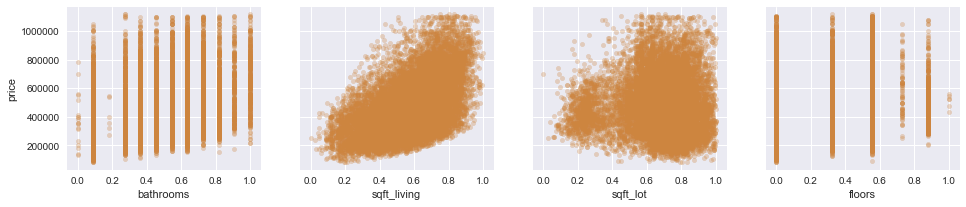

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(df.columns[2:6], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='peru', sharey=True)

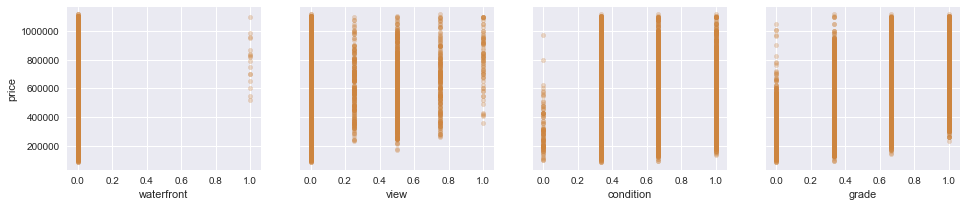

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(df.columns[6:10], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='peru', sharey=True)

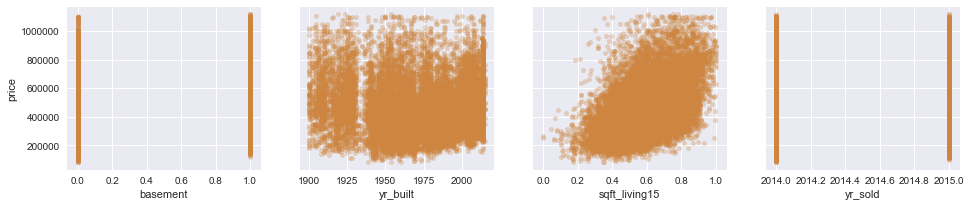

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(df.columns[10:14], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='peru', sharey=True)

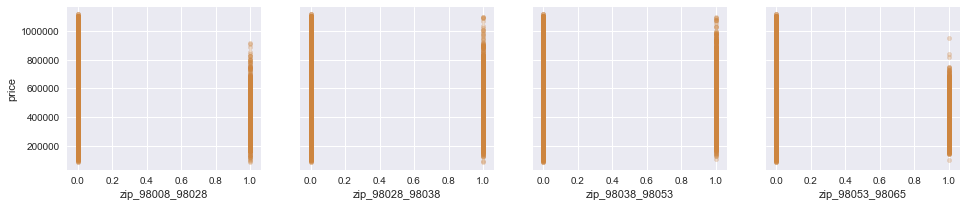

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(df.columns[14:18], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='peru', sharey=True)

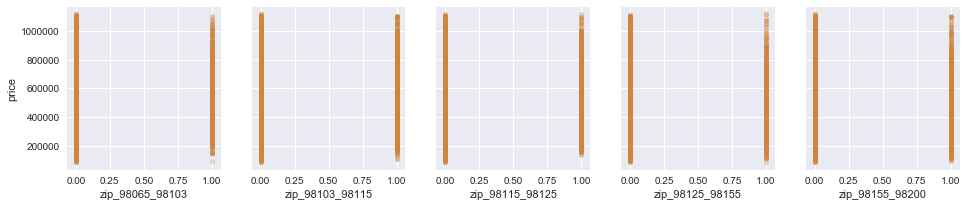

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,3))

for xcol, ax in zip(df.columns[18:24], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='peru', sharey=True)

Based on the scatter plots between features and 'price' target above:

-When the number of bedrooms increase, the price seems to also increases.

-When the number of bathrooms increase, the price seems to also increases.

-There is a linear relationship between footage of the house and the price, but still a lot of variance.

-There is a lot of variance and no distinct linearity between footage of the lot and the price. 

-When the number of floors increase, the price seems to also increases.

-Houses with a waterfront view seem to have higher price. 

-When the number of views increase, the price seems to also increases.

-The higher condition of the house, a slightly higher price.

-Houses with higher grades, according to King County grading system, seem to have higher prices

-Houses with a basement have a slightly higher price.

-No linear relationship between built year and the price, just a lot of variance.

-There is a linear relationship between footage of the house for the nearest 15 neighbors and the price, but still a lot of variance.

-Price seems to be equally distributed between houses sold in 2014 and in 2015. No linearity from the plot.

-Some zipcode bins show prices with equal distribution.

For further investigation before eliminating features with week linearity, the correlation values between each feature and the target are calculated and showed below

In [17]:
corr = df.corr()
corr.iloc[1:,0:1]

,price
bedrooms,0.244855
bathrooms,0.355507
sqft_living,0.515496
sqft_lot,-0.058626
floors,0.219770
waterfront,0.056506
view,0.248769
condition,0.084566
grade,0.537324
basement,0.205914


Features with low correlation values (less than 0.2) with the target are the ones that have weak linear relationships with the target. Therefore, these features are eliminated 

In [18]:
df = df.drop(columns=['sqft_lot','waterfront','condition','yr_built','yr_sold','zip_98008_98028','zip_98028_98038',
                      'zip_98038_98053','zip_98053_98065','zip_98065_98103','zip_98103_98115','zip_98115_98125',
                      'zip_98125_98155','zip_98155_98200']).copy()
df.head()

,price,bedrooms,bathrooms,sqft_living,floors,view,grade,basement,sqft_living15
0,221900.0,0.333333,0.090909,0.369910,0.000000,0.0,0.333333,0.0,0.435422
1,538000.0,0.333333,0.545455,0.756227,0.553295,0.0,0.333333,1.0,0.566527
2,180000.0,0.000000,0.090909,0.158049,0.000000,0.0,0.000000,0.0,0.835396
3,604000.0,0.666667,0.818182,0.621749,0.000000,0.0,0.333333,1.0,0.443792
4,510000.0,0.333333,0.454545,0.545243,0.000000,0.0,0.666667,0.0,0.602153


In [19]:
outcome = 'price'
predictors = df.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1361.
Date:                Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                        17:33:21   Log-Likelihood:            -2.2140e+05
No. Observations:               16614   AIC:                         4.428e+05
Df Residuals:                   16605   BIC:                         4.429e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.225e+05   4781.633     25.622      0.000    1.13e+05    1.32e+05
bedrooms      -3.174e+04   5810.337     -5.463      0.000   -4.31e+04   -2.04e+04
bathrooms     -1.055e+05   7678.377    -13.743      0.000   -1.21e+05   -9.05e+04
sqft_living    2.846e+05   1.31e+04     21.699      0.000    2.59e+05     3.1e+05
floors         5.183e+04   5476.009      9.465      0.000    4.11e+04    6.26e+04
view           1.814e+05   8305.471     21.842      0.000    1.65e+05    1.98e+05
grade          2.457e+05   6159.928     39.882      0.000    2.34e+05    2.58e+05
basement       6.284e+04   2771.388     22.675      0.000    5.74e+04    6.83e+04
sqft_living15  1.251e+05   1.09e+04     11.491      0.000    1.04e+05    1.46e+05
==============================================================================
Omnibus:                      911.269   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1084.047
Skew:                           0.582   Prob(JB):                    4.00e-236
Kurtosis:                       3.459   Cond. No.                         20.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although the R-squared and Adj.R-squared values decreased quite a bit, the features that have weak linearity should still not be added back to the dataset as they might affect the correlation of the model 

## Check for Heteroscedasticity and Normality

The remaining predictors are checked to see whether they violate the the heteroscedasticity (the predictors' variability is equal across values of the target) and normality assumptions (the residuals are normally distributed). 

King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~bedrooms
-------------------------------------------------------------------------------------


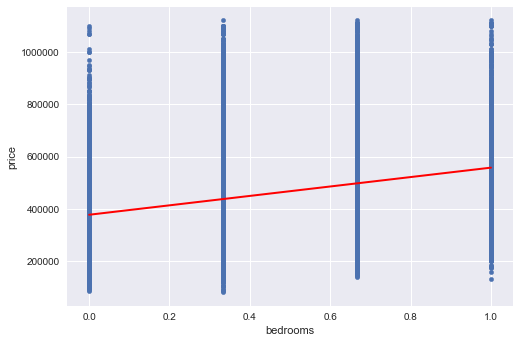

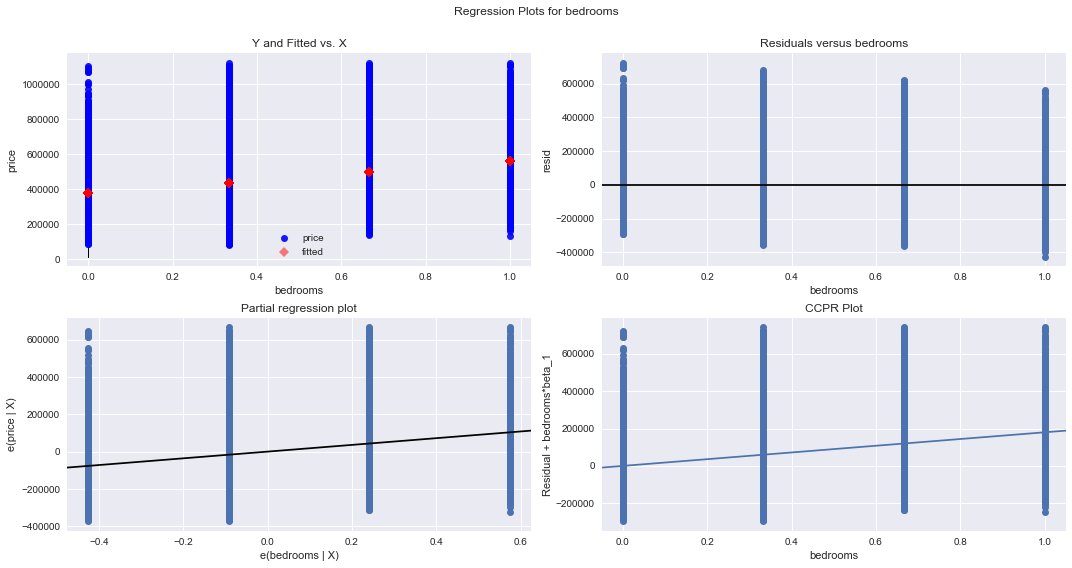

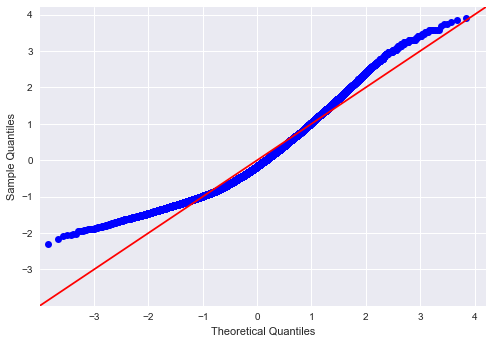

King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~bathrooms
-------------------------------------------------------------------------------------


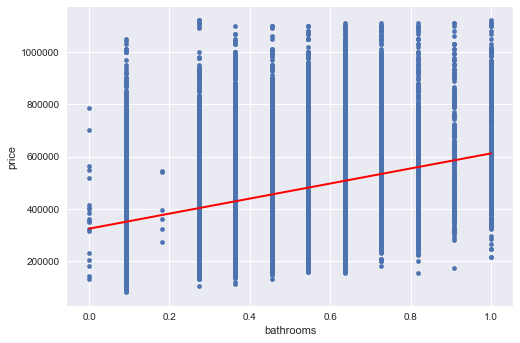

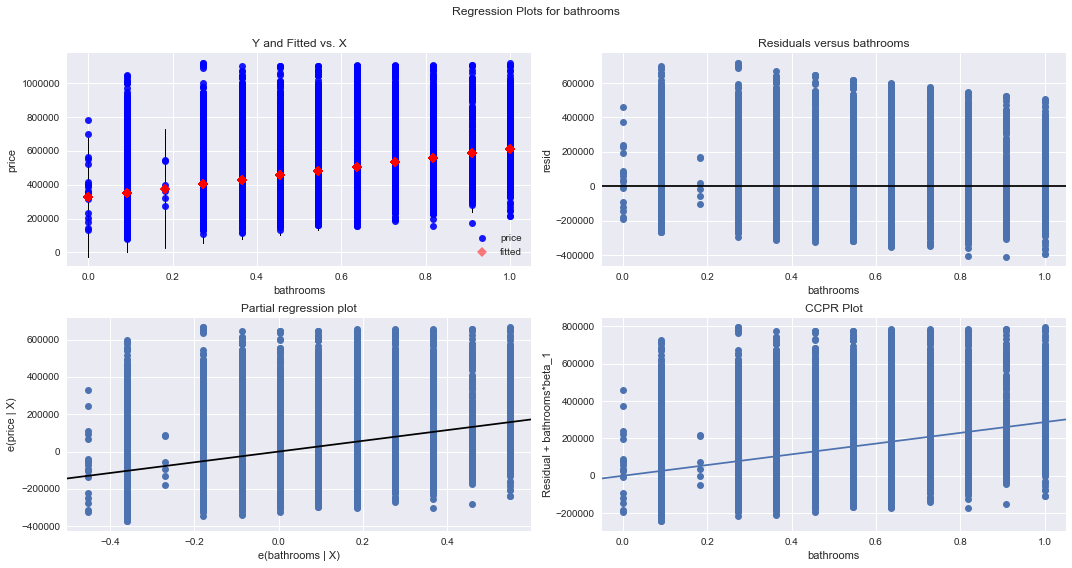

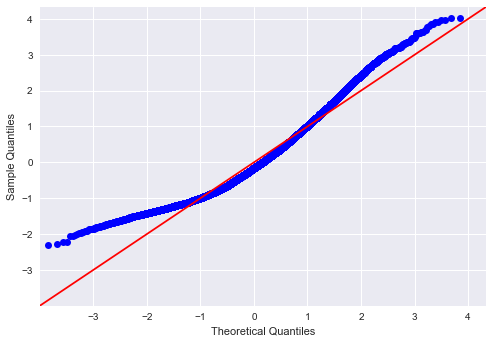

King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~sqft_living
-------------------------------------------------------------------------------------


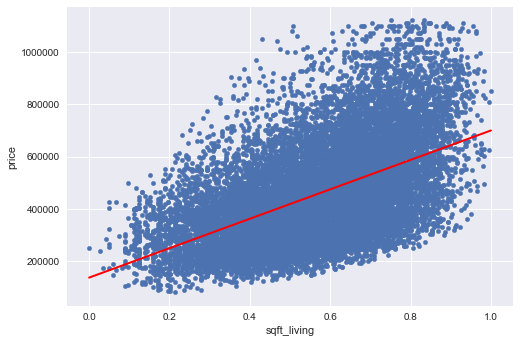

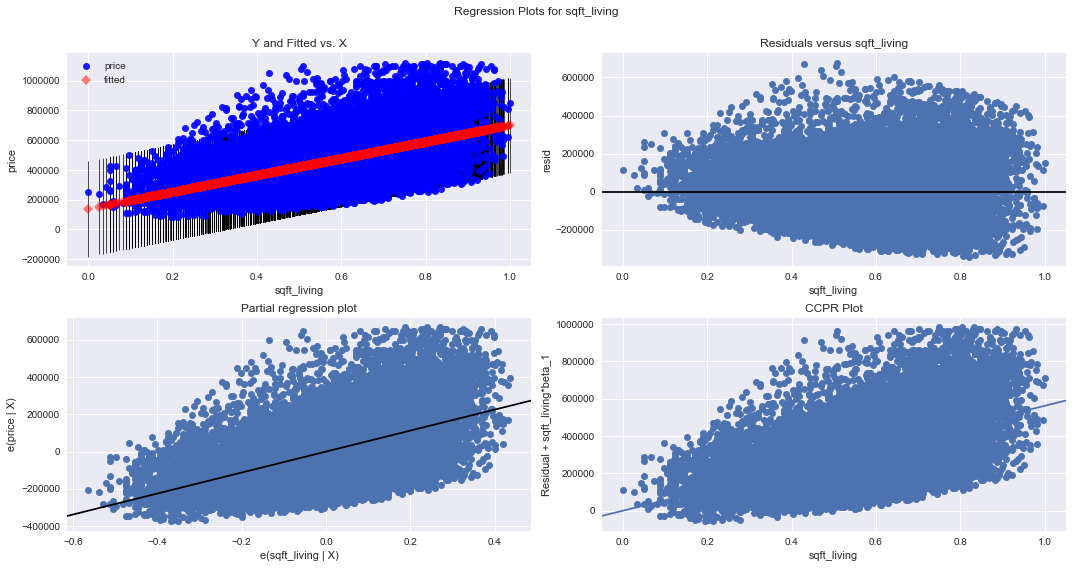

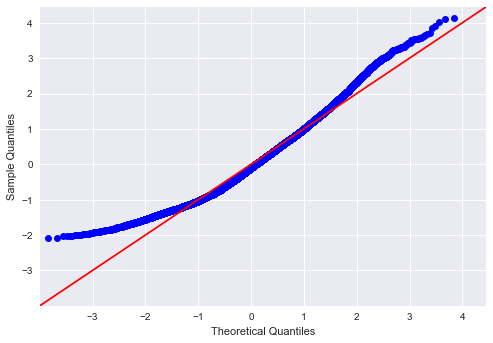

King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~floors
-------------------------------------------------------------------------------------


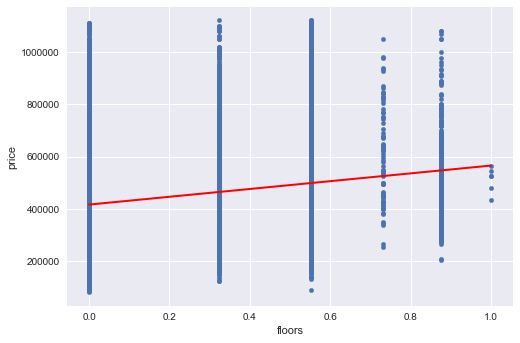

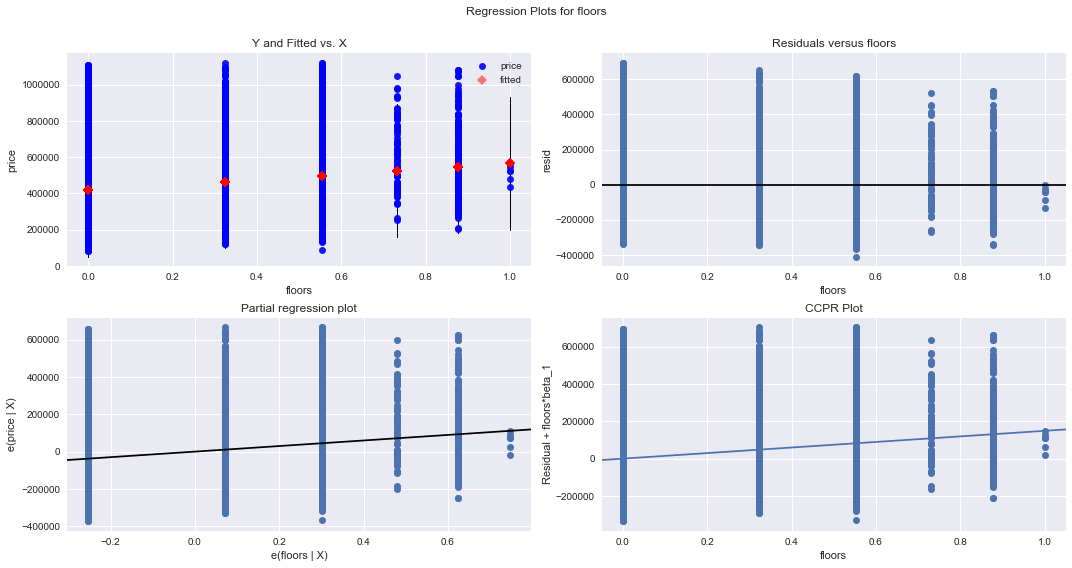

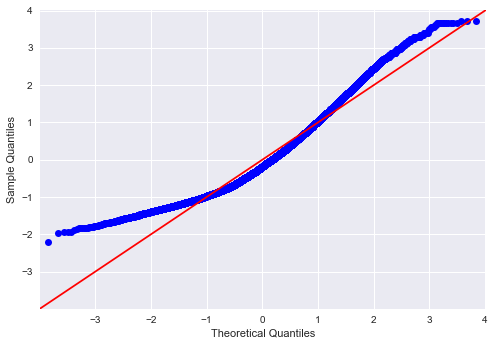

King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~view
-------------------------------------------------------------------------------------


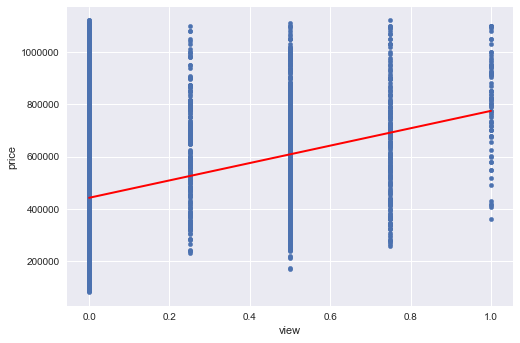

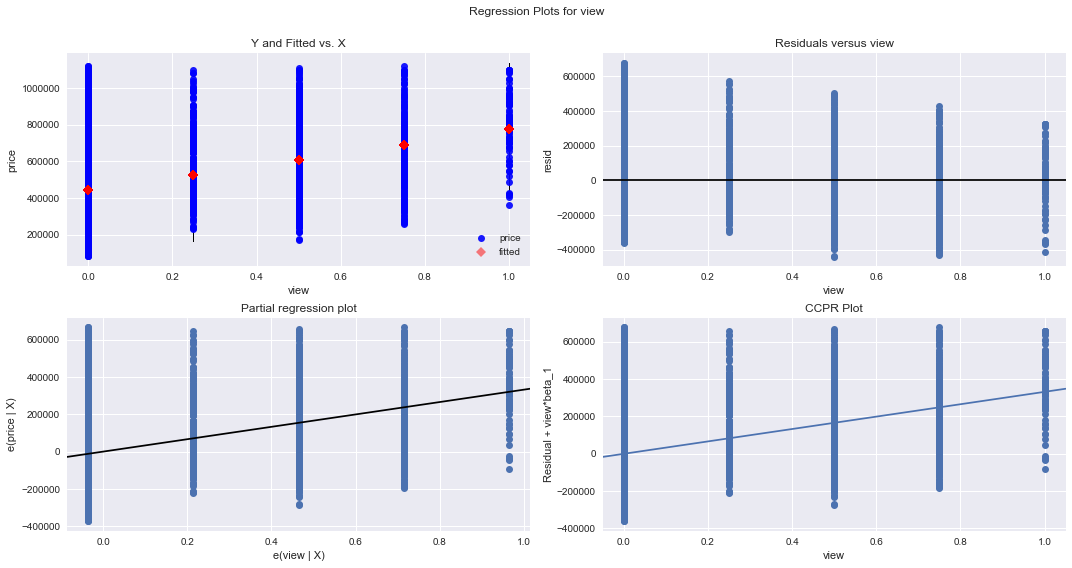

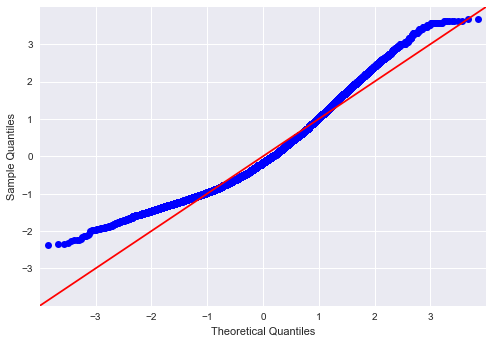

King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~grade
-------------------------------------------------------------------------------------


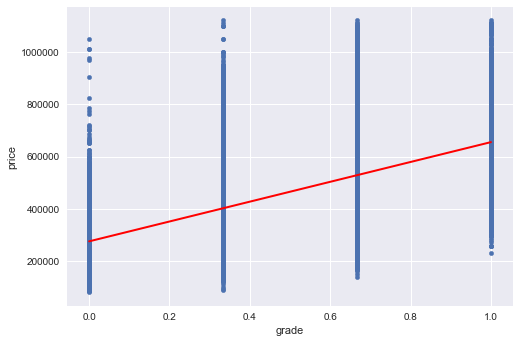

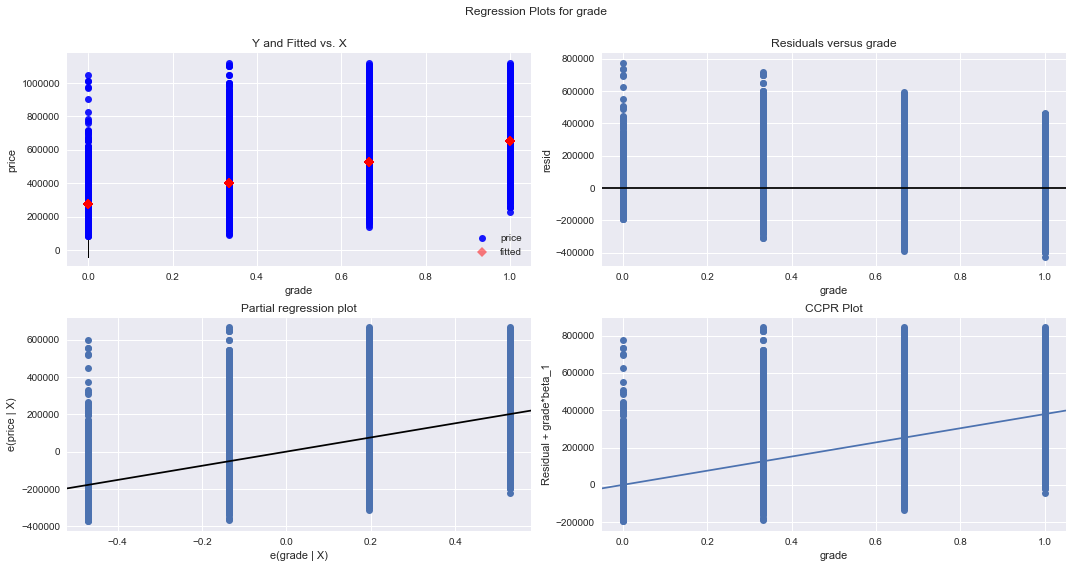

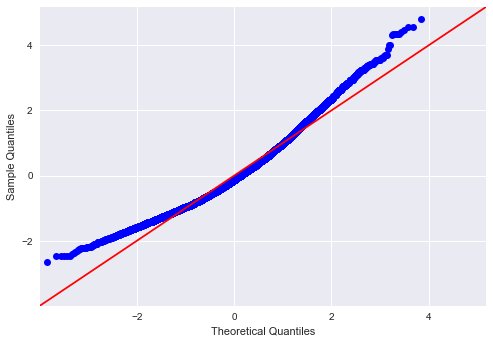

King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~basement
-------------------------------------------------------------------------------------


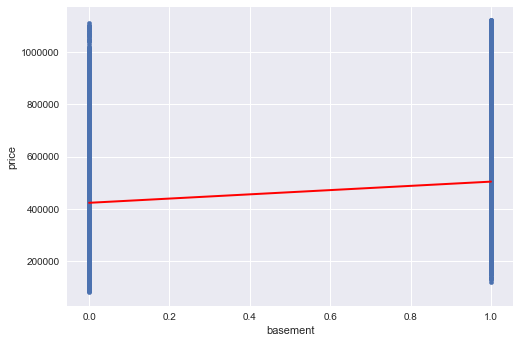

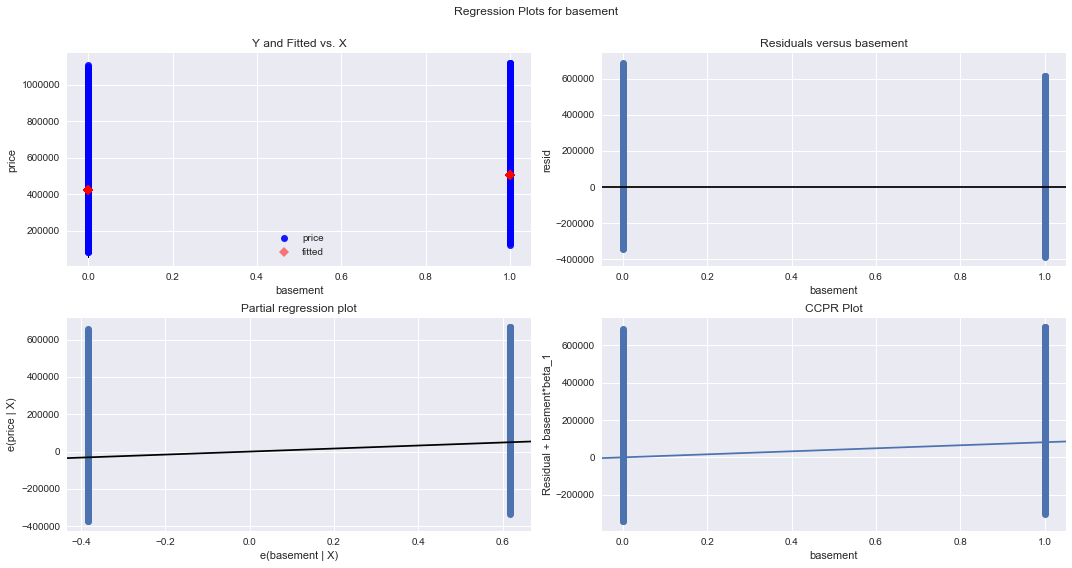

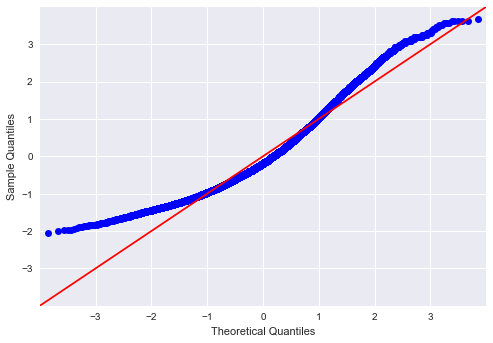

King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~sqft_living15
-------------------------------------------------------------------------------------


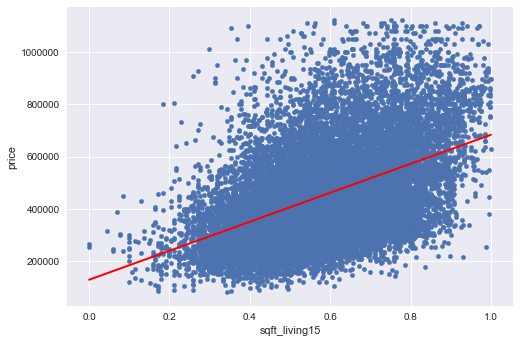

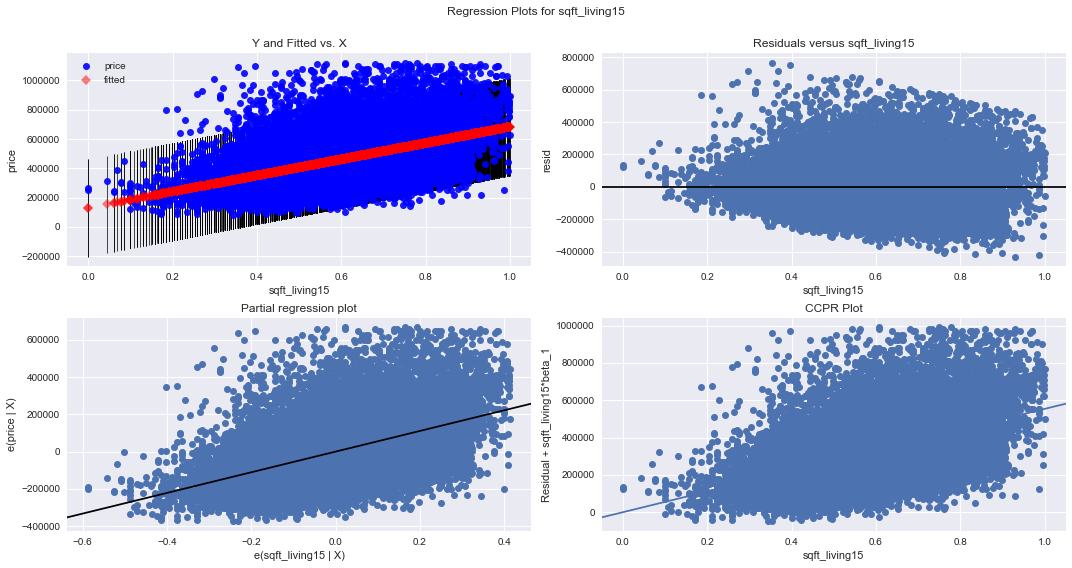

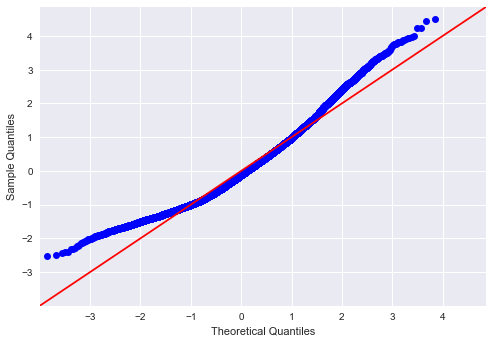

In [25]:
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)']]
for idx, val in enumerate(['bedrooms','bathrooms','sqft_living','floors','view','grade','basement','sqft_living15']):
    print ("King County Housing DataSet - Regression Analysis and Diagnostics for formula: price~" + val)
    print ("-------------------------------------------------------------------------------------")

    f = 'price~' + val   
    model = ols(formula=f, data=df).fit()
    
    X_new = pd.DataFrame({val: [df[val].min(), df[val].max()]});
    preds = model.predict(X_new)
    df.plot(kind='scatter', x=val, y='price');
    plt.plot(X_new, preds, c='red', linewidth=2);
    plt.show()
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, val, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    
    plt.show()
    
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

In [26]:
pd.DataFrame(results, columns=['ind_var','r-squared','intercept','slope','p-value','normality(JB)'])

,ind_var,r-squared,intercept,slope,p-value,normality(JB)
0,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,bedrooms,0.0599538,377809,179904,2.3967e-225,1650.69
2,bathrooms,0.126385,324674,287346,0,1847.7
3,sqft_living,0.265736,137539,561924,0,1067.2
4,floors,0.048299,416672,148950,7.49279e-181,2006.38
5,view,0.0618862,442599,331914,8.90986e-233,1749.21
6,grade,0.288717,276263,378923,0,1599.78
7,basement,0.0424006,423435,80850.7,1.55071e-158,1863.55
8,sqft_living15,0.210462,129497,553563,0,1627.95


## Check for Normality 